In [45]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
import json
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_boston
from sklearn.metrics import r2_score

import torch.utils.data
from sklearn.model_selection import train_test_split

import torch
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [91]:
train = pd.read_csv("./Data_Train.csv", keep_default_na=False)
test = pd.read_csv("./Test_set.csv", keep_default_na=False)

# train = train[0:30]
print(train.columns)

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')


In [92]:
def preprocess_data(dataset):
    dataset["Total_Stops"] = dataset["Total_Stops"].str.replace("non-stop", "0 stop")
    dataset["Total_Stops"] = dataset["Total_Stops"].str.slice(stop=1)
    dataset["Total_Stops"].fillna(0,inplace = True)
    dataset["Total_Stops"] = pd.to_numeric(dataset["Total_Stops"], downcast='float').fillna(0)

    dataset['Date_of_Journey'] = pd.to_datetime(dataset['Date_of_Journey']).dt.date

    dataset['Duration'] = pd.to_timedelta(dataset['Duration'])
    dataset['Dep_Time'] = pd.to_datetime(dataset['Dep_Time']).dt.time

    dataset['Duration_min'] = dataset['Duration'].dt.seconds / 60

    dataset.loc[dataset['Arrival_Time'].str.len() > 6, 'Arrival_Date'] = pd.to_datetime(dataset['Arrival_Time']).dt.date
    dataset["Arrival_Date"].fillna(dataset['Date_of_Journey'],inplace = True)


    dataset['Arrival_Time'] = pd.to_datetime(dataset['Arrival_Time']).dt.time

    dataset['Business_class'] = dataset['Additional_Info'].str.count("Business class")
    dataset['Business_class'] = dataset['Business_class'].astype(int)

    dataset.loc[dataset['Additional_Info'].str.count("Long layover")>0, 'Long_layover'] = dataset["Additional_Info"].str.replace("Long layover", "")
    dataset["Long_layover"] = pd.to_numeric(dataset["Long_layover"].str.strip())
    dataset["Long_layover"].fillna(0,inplace = True)
    dataset['Long_layover'] = dataset['Long_layover'].astype(int)

    dataset["In_flight_meal"] = dataset['Additional_Info'].str.count("In-flight meal not included")
    dataset["In_flight_meal"].fillna(0,inplace = True)
    dataset['In_flight_meal'] = dataset['In_flight_meal'].astype(int)

    dataset["No_checkin_baggage"] = dataset['Additional_Info'].str.count("No check-in baggage included")
    dataset["No_checkin_baggage"].fillna(0,inplace = True)
    dataset['No_checkin_baggage'] = dataset['No_checkin_baggage'].astype(int)


    dataset['Arrival_Date'] = dataset['Arrival_Date'].astype(str)
    dataset['Date_of_Journey'] = dataset['Date_of_Journey'].astype(str)
    dataset['Arrival_Time'] = dataset['Arrival_Time'].astype(str)
    dataset['Dep_Time'] = dataset['Dep_Time'].astype(str)
    dataset = dataset.drop(['Additional_Info'],axis=1)
    dataset = dataset.drop(['Duration'],axis=1)
    return dataset

In [93]:
train = preprocess_data(train)
test = preprocess_data(test)

display(train.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Price,Duration_min,Arrival_Date,Business_class,Long_layover,In_flight_meal,No_checkin_baggage
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR -- DEL,22:20:00,01:10:00,0.0,3897,170.0,2019-03-22,0,0,0,0
1,Air India,2019-01-05,Kolkata,Banglore,CCU -- IXR -- BBI -- BLR,05:50:00,13:15:00,2.0,7662,445.0,2019-01-05,0,0,0,0
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL -- LKO -- BOM -- COK,09:25:00,04:25:00,2.0,13882,1140.0,2019-06-10,0,0,0,0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU -- NAG -- BLR,18:05:00,23:30:00,1.0,6218,325.0,2019-12-05,0,0,0,0
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR -- NAG -- DEL,16:50:00,21:35:00,1.0,13302,285.0,2019-01-03,0,0,0,0


In [94]:
train.dtypes

Airline                object
Date_of_Journey        object
Source                 object
Destination            object
Route                  object
Dep_Time               object
Arrival_Time           object
Total_Stops           float32
Price                   int64
Duration_min          float64
Arrival_Date           object
Business_class          int64
Long_layover            int64
In_flight_meal          int64
No_checkin_baggage      int64
dtype: object

In [95]:
cols = ('Airline','Route','Date_of_Journey','Source','Destination','Dep_Time','Arrival_Time', 'Arrival_Date')
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(np.concatenate((train[c].values, test[c].values), axis=None))) 
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))

display(train.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Price,Duration_min,Arrival_Date,Business_class,Long_layover,In_flight_meal,No_checkin_baggage
0,3,11,0,5,19,211,12,0.0,3897,170.0,19,0,0,0,0
1,1,2,3,0,88,31,104,2.0,7662,445.0,2,0,0,0,0
2,4,35,2,1,123,70,30,2.0,13882,1140.0,68,0,0,0,0
3,3,38,3,0,96,164,217,1.0,6218,325.0,89,0,0,0,0
4,3,0,0,5,30,149,194,1.0,13302,285.0,0,0,0,0,0


In [96]:
cat = len(train.select_dtypes(include=['object']).columns)
num = len(train.select_dtypes(include=['int64','float64']).columns)
print('Total Features: ', cat, 'categorical', '+', num, 'numerical', '=', cat+num, 'features')

Total Features:  0 categorical + 14 numerical = 14 features


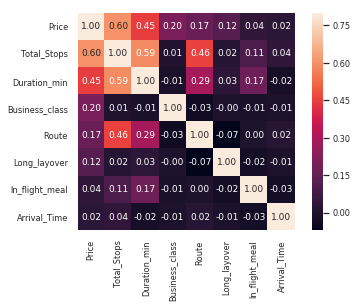

In [97]:
k = 8
corrmat = train.corr()
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=0.75)
sns.heatmap(cm, cbar=True, annot=True, square=True, vmax=.8, fmt='.2f', yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [98]:
col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('Price')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('Price',axis = 1))
mat_y = np.array(train.Price).reshape((10683,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)

test = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

test_set  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

display(train.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Price,Duration_min,Arrival_Date,Business_class,Long_layover,In_flight_meal,No_checkin_baggage
0,0.272727,0.282051,0.00,1.0,0.143939,0.950450,0.054054,0.00,0.027497,0.118467,0.211111,0.0,0.0,0.0,0.0
1,0.090909,0.051282,0.75,0.0,0.666667,0.139640,0.468468,0.50,0.075920,0.310105,0.022222,0.0,0.0,0.0,0.0
2,0.363636,0.897436,0.50,0.2,0.931818,0.315315,0.135135,0.50,0.155917,0.794425,0.755556,0.0,0.0,0.0,0.0
3,0.272727,0.974359,0.75,0.0,0.727273,0.738739,0.977477,0.25,0.057348,0.226481,0.988889,0.0,0.0,0.0,0.0
4,0.272727,0.000000,0.00,1.0,0.227273,0.671171,0.873874,0.25,0.148457,0.198606,0.000000,0.0,0.0,0.0,0.0


In [99]:
display(test.head())

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Duration_min,Arrival_Date,Business_class,Long_layover,In_flight_meal,No_checkin_baggage
0,0.363636,0.666667,0.50,0.2,0.825758,0.707207,0.135135,0.25,0.456446,0.744444,0.0,0.0,0.0,0.0
1,0.272727,0.974359,0.75,0.0,0.719697,0.166667,0.324324,0.25,0.167247,0.988889,0.0,0.0,0.0,0.0
2,0.363636,0.512821,0.50,0.2,0.825758,0.792793,0.752252,0.25,0.993031,0.600000,0.0,0.0,1.0,0.0
3,0.545455,0.512821,0.50,0.2,0.825758,0.247748,0.846847,0.25,0.543554,0.588889,0.0,0.0,0.0,0.0
4,0.000000,0.769231,0.00,0.4,0.143939,1.000000,0.090090,0.00,0.118467,0.866667,0.0,0.0,0.0,0.0


In [55]:
COLUMNS = col_train
FEATURES = col_train_bis
LABEL = "Price"

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS]
prediction_set = train.Price

# print(prediction_set)

X_train, X_val, y_train, y_val = train_test_split(training_set[FEATURES] , prediction_set, test_size=0.1, random_state=42)

train_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values))
val_set = torch.utils.data.TensorDataset(torch.FloatTensor(X_val.values), torch.FloatTensor(y_val.values))

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size)

# test_loader = torch.utils.data.DataLoader(torch.FloatTensor(test.values),batch_size=batch_size)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [65]:
# Hyperparameters
batch_no = len(X_train) // batch_size  #batches
cols=X_train.shape[1] #Number of columns in input matrix
n_output=1

# Sequence Length
sequence_length = 6  # of words in a sequence 892110
# Batch Size
# batch_size = 128
# train_loader = batch_data(int_text, sequence_length, batch_size)
# Number of Epochs
num_epochs = 2000
# Learning Rate
learning_rate = 0.0002
# Model parameters
# Input size
input_size = cols
# Output size
output_size = 1
# Embedding Dimension
embedding_dim = 128
# Hidden Dimension
hidden_dim = 128
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 50

In [57]:
boston = load_boston()
print( "Type of boston dataset:", type(boston))
boston_df = pd.DataFrame(boston['data'] )
boston_df.columns = boston['feature_names']
boston_df['PRICE']= boston['target']
display(boston_df.head())

Type of boston dataset: <class 'sklearn.utils.Bunch'>


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


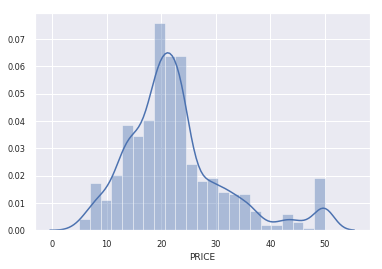

In [58]:
sns.distplot(boston_df['PRICE']);

In [59]:
# sns.pairplot(boston_df);

In [60]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, input_size, n_layers, output_size, dropout=0.5):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        # self.embedding = nn.Embedding(input_size, embedding_dim)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=output_size)
        # self.sig = nn.Sigmoid()        
        # self.word_dict = None
        
        # self.fc1 = nn.Linear(input_size, hidden_dim * 2)
        # self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        # self.fc3 = nn.Linear(hidden_dim, output_size)
        # self.dropout = nn.Dropout(p=0.25)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.08
        # self.embedding.weight.data.uniform_(-initrange, initrange)
        self.lstm.weight_ih_l0.data.uniform_(-initrange, initrange)
        self.lstm.weight_hh_l0.data.uniform_(-initrange, initrange)
        
        self.lstm.bias_ih_l0.data.zero_()
        self.lstm.bias_hh_l0.data.zero_()
        
        # self.fc.bias.data.zero_()
        self.dense.bias.data.fill_(0)
        # self.fc.weight.data.uniform_(-initrange, initrange)
        self.dense.weight.data.normal_(0.0, (1.0 / np.sqrt(self.dense.in_features)))
        
    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        batch_size = x.size(0)
        # print(x.shape)
        # x = x.permute(14, 32)
        # x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        # out = self.fc3(x)
        # x = x.permute(2, 0, 1)
        # print(batch_size)
        # print(x.shape)
        # x = x.t()
        # embeds = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        # avg_pool_l = torch.mean(lstm_out.permute(1, 0, 2), 1)
        # max_pool_l, _ = torch.max(lstm_out.permute(1, 0, 2), 1)
        # print(avg_pool_l)
        # x = torch.cat((avg_pool_l, max_pool_l), 1)
        # print(x.shape)
        out = self.dense(lstm_out)
        # out = self.sig(out.squeeze())
        # print(out)
        # out = out[lengths - 1, range(len(lengths))]
        return out

In [61]:
from torch.autograd import Variable

def forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden_dim, clip=9):

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    hidden = {}
    # hidden = tuple([each.data for each in hidden_dim])
    
    rnn.zero_grad()
    optimizer.zero_grad()
    
    try:
        # get the output from the model
        # output, hidden = rnn(inputs, hidden)
        output = rnn(inputs.unsqueeze(0))
        output = output.squeeze()
        # print(output.shape)
    except RuntimeError:
        raise
    # print(labels)
    loss = criterion(output, labels)
    loss.backward()
    
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(rnn.parameters(),  clip)
   
    optimizer.step()

    return loss.item(), hidden

In [62]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    val_batch_losses = []
    valid_loss_min = np.Inf
    
    rnn.train()
    
    previousLoss = np.Inf
    minLoss = np.Inf

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        # hidden = rnn.init_hidden(batch_size)
        hidden = {}
        # print("epoch ",epoch_i)
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            # batch_last = batch_i
            # n_batches = len(train_loader.dataset) // batch_size
            
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden, clip=5)          
            # record loss
            batch_losses.append(loss)
            
        for batch_i, (inputs, labels) in enumerate(val_loader, 1):
            # batch_last = batch_i
            # n_batches = len(val_loader.dataset) // batch_size
            # if(batch_i > n_batches):
                # break
            
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden, clip=5)          
            # record loss
            val_batch_losses.append(loss)

        # printing loss stats
        if epoch_i%show_every_n_batches == 0:
            average_loss = np.average(batch_losses)
            val_average_loss = np.average(val_batch_losses)
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch_i, average_loss, val_average_loss))

            ## TODO: save the model if validation loss has decreased
            # save model if validation loss has decreased
            if val_average_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_average_loss))
                with open('./save/trained_rnn_new', 'wb') as pickle_file:
                    # print(pickle_file)
                    torch.save(rnn, pickle_file)
                valid_loss_min = val_average_loss

            batch_losses = []
            val_batch_losses = []
            
    return rnn

In [66]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

In [67]:
# create model and move to gpu if available
# rnn = RNN(input_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.25)
# rnn.apply(weight_init)
rnn = LSTMClassifier(embedding_dim, hidden_dim, input_size, n_layers, output_size)

if train_on_gpu:
    rnn.cuda()

decay_rate = learning_rate / num_epochs

# print(decay_rate)
# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate, momentum=0.9, weight_decay=decay_rate)

# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss(size_average=False)
# rnn = helper.load_model('./save/trained_rnn_new')

# training the model
trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
# helper.save_model('./save/trained_rnn', trained_rnn)
print('Model Trained and Saved')


Training for 2000 epoch(s)...
Epoch: 50 	Training Loss: 0.056419 	Validation Loss: 0.059528
Validation loss decreased (inf --> 0.059528).  Saving model ...
Epoch: 100 	Training Loss: 0.047057 	Validation Loss: 0.047853
Validation loss decreased (0.059528 --> 0.047853).  Saving model ...
Epoch: 150 	Training Loss: 0.043801 	Validation Loss: 0.043849
Validation loss decreased (0.047853 --> 0.043849).  Saving model ...
Epoch: 200 	Training Loss: 0.041654 	Validation Loss: 0.041318
Validation loss decreased (0.043849 --> 0.041318).  Saving model ...
Epoch: 250 	Training Loss: 0.039502 	Validation Loss: 0.039425
Validation loss decreased (0.041318 --> 0.039425).  Saving model ...
Epoch: 300 	Training Loss: 0.037806 	Validation Loss: 0.037311
Validation loss decreased (0.039425 --> 0.037311).  Saving model ...
Epoch: 350 	Training Loss: 0.036501 	Validation Loss: 0.035676
Validation loss decreased (0.037311 --> 0.035676).  Saving model ...
Epoch: 400 	Training Loss: 0.035414 	Validation Loss

In [68]:
def predict(model, inputs):

    if(train_on_gpu):
        inputs = inputs.cuda()
    
    try:
        output = model(inputs.unsqueeze(0))
        output = output.squeeze()
    except RuntimeError:
        raise
    
    # prediction = np.array(output).argmax(0)
    # p = F.softmax(output, dim=1).data
    p = output.cpu().detach().numpy().flatten()
    prediction = np.argmax(p)
    # print(prediction)
    return p

In [ ]:
# display(test)

In [100]:
model_rnn = torch.load("./save/trained_rnn_new")
model_rnn.eval()

X = Variable(torch.FloatTensor(X_train.values)) 
pred = predict(model_rnn, X)
print(X)
# pred= result
print(len(pred),len(y_train))
r2_score(pred,y_train.values, multioutput="variance_weighted")


tensor([[0.0909, 0.0769, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3636, 0.2051, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.3636, 0.0256, 0.7500,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.5455, 0.4615, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2727, 0.1026, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3636, 0.0769, 0.5000,  ..., 0.0000, 1.0000, 0.0000]])
9614 9614


0.8205724757798358

In [101]:
test_X = Variable(torch.FloatTensor(test.values))
print(test_X)
test_pred = predict(model_rnn, test_X)
print(test_pred)
print(len(test_pred))
# print(np.array(test_p).reshape(9614,1))

tensor([[0.3636, 0.6667, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.2727, 0.9744, 0.7500,  ..., 0.0000, 0.0000, 0.0000],
        [0.3636, 0.5128, 0.5000,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.3636, 0.5897, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0909, 0.5897, 0.5000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5455, 0.6923, 0.5000,  ..., 0.0000, 0.0000, 0.0000]])
[0.16852318 0.04913662 0.12655114 ... 0.21539256 0.09225603 0.11759075]
2671


In [103]:
predictions = pd.DataFrame(prepro_y.inverse_transform(np.array(test_pred).reshape(2671,1)), columns = ["Price"])
predictions["Price"] = predictions["Price"]
# predictions = predictions.round(0).astype(int)
display(predictions.head())


,Price
0,14862.183594
1,5579.520020
2,11598.731445
3,10642.082031
4,4358.259766


In [104]:
predictions.to_excel("output.xlsx")

In [ ]:
test["Price"] = pred_price
display(test.head())

In [ ]:
predicted_test = scaler.inverse_transform(test)
display(predicted_test[0])

In [ ]:
batch_output = []
print(len(test_set.values))

for i, data in enumerate(torch.FloatTensor(test_set.values), 1):
    data = data.unsqueeze(0)
    # print(data)
    # print(data.shape)
    p = predict(model_rnn, data)
    # print(p)
    batch_output.append(p[0])

# print(batch_output)
# for batch_i, inputs in enumerate(test_loader, 1):
    # batch_last = batch_i
    # n_batches = len(train_loader.dataset) // batch_size

    #output = predict(model, optimizer, criterion, inputs)     
    # record loss
    #batch_output.append(output)

In [ ]:
pred_price  = pd.DataFrame(batch_output,columns = ["Price"])
display(pred_price.head())

In [ ]:
test_set["Price"] = pred_price
display(test_set.head())

In [ ]:
predicted_test = scaler.inverse_transform(test_set)
display(predicted_test)